In [1]:
using BenchmarkTools
using Plots
using DRR
using Zygote

In [2]:
volume, ΔX, ΔY, ΔZ = read_dicom("../data/cxr"; pad=true)
grid = volume2grid(volume, ΔX, ΔY, ΔZ)

# Define the camera
center = Vec3(180., 180., -100)
camera = Camera(center)

# Define the detector plane
center = Vec3(180., 180., 500.)
normal = Vec3(1., -1., -1.)
height, width = 601, 601
Δx, Δy = 2., 2.
detector = Detector(center, normal, height, width, Δx, Δy)

Detector(Vec3{Float64}(180.0, 180.0, 500.0), Vec3{Float64}(1.0, -1.0, -1.0), 601, 601, 2.0, 2.0)

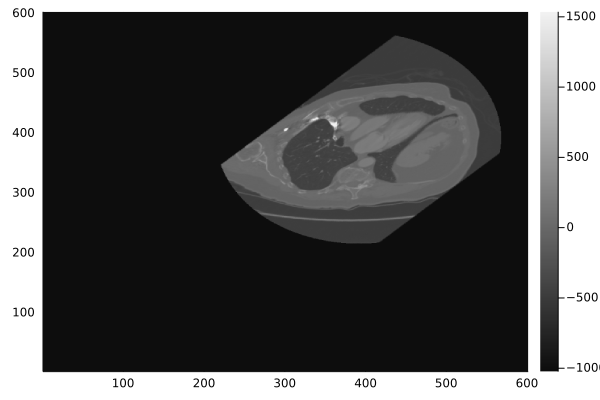

In [3]:
# Generate the DRR
spacing = 0.51
drr = make_drr(grid, volume, camera, detector, spacing)
heatmap(drr, c=:grays)

In [8]:
function raytrace_trilinear(ray, spacing::Float64, grid, volume)
    pts = trace.(0:spacing:1; ray=ray)
    interpolations = interpolate.(pts; grid, volume)
    return sum(interpolations) / length(pts)
end
    

raytrace_trilinear (generic function with 1 method)

In [5]:
findz(x, y; a, b, c, d) = (d - a * x - b * y) / c
findz(x::Tuple{Float64,Float64}; a, b, c, d) = findz(x[1], x[2]; a, b, c, d)
append(xy, z) = Vec3(xy..., z)

# Construct the detector array
function make_plane(detector::Detector)
    d = dotprod(detector.center, detector.normal)
    xs = (-detector.height÷2:1:detector.height÷2) * detector.Δx
    ys = (-detector.width÷2:1:detector.width÷2) * detector.Δy
    xys = product(xs, ys) |> collect
    zs = findz.(xys; a=detector.normal.x, b=detector.normal.y, c=detector.normal.z, d=d)
    return append.(xys, zs)
end
get_rays(camera, plane) = [Ray(camera.center, pixel - camera.center) for pixel in plane]

import Base: product
# Set up the detector plane
plane = make_plane(detector)
projector = get_rays(camera, plane);

In [23]:
ray = projector[300,300]

DRR.Ray_{Float64}(Vec3{Float64}(180.0, 180.0, -100.0), Vec3{Float64}(-182.0, -182.0, 600.0), 652.876711179071)

In [29]:
grd = gradient(volume -> raytrace_trilinear(ray, spacing, grid, volume), volume)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],)

In [41]:
test = sum(grd[1])

0.5

It does give a gradient! There are values somewhere in there. 

In [22]:
raytrace_trilinear(projector[300,301], spacing, grid, volume)

-38.16126848687418

In [ ]:
# jacobian(spc -> make_drr(grid, volume, camera, detector, spc), spacing)